# CNN(합성곱 신경망)을 이용한 MNIST 손글씨 인식하기

### MNIST 손글씨 데이타셋 

<img src="./img/mnist_data.PNG" align=left width=500>

- MNIST 데이터셋은 미국 국립표준기술원(NIST)이 고등학생과 인구조사국 직원등이 쓴 손글씨를 이용해 만든 데이터로 구성
- 70,000개의 글자 이미지에 각각 0부터 9까지 이름표를 붙인 데이터셋
- 70,000개 = 60,000개 학습 데이타 셋 + 10,000개의 테스트 셋으로 구성

In [1]:
# 경고 무시
from warnings import filterwarnings
filterwarnings("ignore")

## CNN을 이용한 MNIST 손글씨 인식

### 1. 데이타 준비
- 1) 데이타셋 로드
- 2) 피쳐 정규화
- 3) 레이블 원-핫 인코딩
- 4) 검증 데이타셋 분리

In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy
import os
import tensorflow as tf

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# 데이터 불러오기 - 학습 데이타셋, 테스트 데이타셋
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape[0])
print(X_test.shape[0])

60000
10000


In [6]:
# 피쳐 정규화
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 클래스 원-핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
# 검증 데이타셋 만들기
from sklearn.model_selection import train_test_split
# 학습/검증 데이터셋을 0.7:0.3의 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.3, 
                                                  random_state = 0,
                                                  stratify = y_train)
# 데이타 형태 확인
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(42000, 28, 28, 1) (42000, 10)
(18000, 28, 28, 1) (18000, 10)
(10000, 28, 28, 1) (10000, 10)


### 2. 컨볼루션 신경망(CNN) 모델 구성

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy
import os
import tensorflow as tf

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
# 컨볼루션 신경망 모델 구성
model = Sequential()

# 컨볼루션 신경망(CNN) 
# 1) 입력층 - 28*28*1, CNN층1 - 필터수: 32, 커널사이즈: (3,3), 활성화함수: relu
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu')) 

# 2) CNN층2 - 필터수: 64, 커널사이즈: (3,3), 활성화함수: relu
model.add(Conv2D(64, (3, 3), activation='relu'))

# 3) 맥스 풀링층 : (2,2)
model.add(MaxPooling2D(pool_size=2))

# 4) 드롭 아웃 : 25%
model.add(Dropout(0.25))

# 5) 플래튼 : 1차원으로 변경
model.add(Flatten())

# 6) 은닉층: Dense층, 노드: 512, 활성화함수: relu
model.add(Dense(512,  activation='relu'))

# 7) 드롭 아웃: 50%
model.add(Dropout(0.5))

# 8) 출력층 - 출력수 : 10개(0~9), 활성화함수 - softmax
model.add(Dense(10, activation='softmax'))

#### 모델 구조 확인

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 512)               4719104   
                                                        

### 3. 컴파일 설정

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### 4. Early_stopping  콜백 함수를 사용하여 모델 학습

In [12]:
# 모델 최적화 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./model/mnist.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

### 5. 모델 실행

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=30, batch_size=64, 
                    verbose=1,
                    callbacks=[early_stopping_callback, checkpointer])

Epoch 1/30
656/657 [============================>.] - ETA: 0s - loss: 0.1766 - acc: 0.9450
Epoch 1: val_loss improved from inf to 0.05768, saving model to ./model\mnist.hdf5
657/657 [==============================] - 47s 70ms/step - loss: 0.1766 - acc: 0.9450 - val_loss: 0.0577 - val_acc: 0.9837
Epoch 2/30
656/657 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9812
Epoch 2: val_loss improved from 0.05768 to 0.03898, saving model to ./model\mnist.hdf5
657/657 [==============================] - 46s 70ms/step - loss: 0.0610 - acc: 0.9811 - val_loss: 0.0390 - val_acc: 0.9882
Epoch 3/30
656/657 [============================>.] - ETA: 0s - loss: 0.0466 - acc: 0.9849
Epoch 3: val_loss improved from 0.03898 to 0.03642, saving model to ./model\mnist.hdf5
657/657 [==============================] - 47s 71ms/step - loss: 0.0465 - acc: 0.9850 - val_loss: 0.0364 - val_acc: 0.9892
Epoch 4/30
656/657 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9892
Epoch 4: v

### 6. 모델 평가

In [15]:
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 3s 9ms/step - loss: 0.0391 - acc: 0.9914

 Test Accuracy: 0.9914


#### CNN 모델 정확도 : 0.9914

### 7. 학습 과정 그래프 시각화

In [16]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

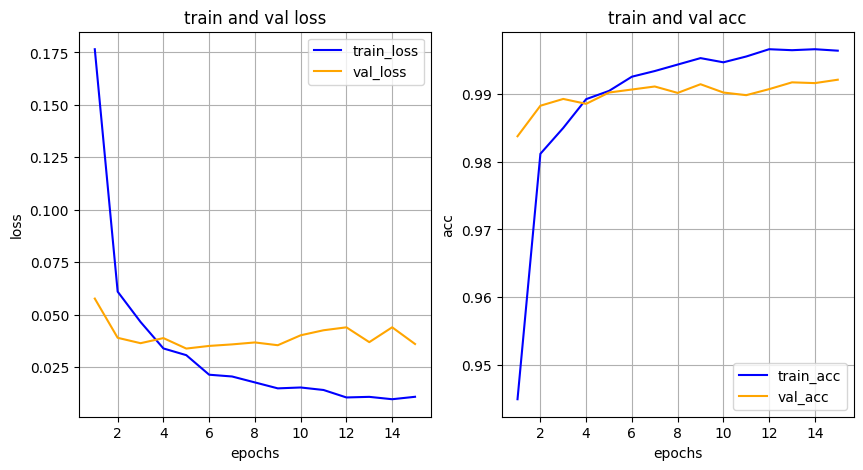

In [17]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] # 검증 데이터가 있는 경우 ‘val_’ 수식어가 붙습니다.

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
ax1.grid()

acc = his_dict['acc']
val_acc = his_dict['val_acc']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()
ax2.grid()

plt.show()

### 8. 모델 예측

In [1]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

model2 = load_model('./model/mnist.hdf5')

In [9]:
# 데이터 불러오기 
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
# 테스트 데이타와 비슷한 데이타 생성
new_data = X_test[0]
# new_data

In [11]:
# 데이타 정규화
import numpy as np
new_data = new_data.reshape(1,28,28,1).astype('float32') / 255
new_data

array([[[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         

In [12]:
# 불러온 모델로 예측하기
import numpy as np
results = model2.predict(new_data)
print(f'각 클래스에 속할 확률: \n{results[0]}')
print(f'예상 클래스: {results[0].argmax()}')
print(f'예상 클래스 확률: {round(results[0][results[0].argmax()]*100, 2)}%')

1/1 [==============================] - 0s 21ms/step
각 클래스에 속할 확률: 
[3.9407416e-10 7.8238763e-08 9.9999988e-01 1.3853919e-11 2.2294307e-15
 1.1206524e-14 2.6156823e-11 8.6677419e-12 4.0409742e-12 3.7344484e-15]
예상 클래스: 2
예상 클래스 확률: 100.0%


### [전체 소스 코드]

In [14]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy
import os
import tensorflow as tf

# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(seed)

# 데이터 불러오기 - 속성/클래스 구분, 학습 데이타 셋/테스트 데이타 셋 구분
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 속성 정규화
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 클래스 원핫 인코딩
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 검증 데이타셋 만들기
# 학습/검증 데이터셋을 0.7:0.3의 비율로 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size = 0.3, 
                                                  random_state = 0,
                                                  stratify = y_train)
# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(seed)

# 컨볼루션 신경망 모델 구성
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# 컴파일 설정
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 최적화 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/mnist.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

# 모델 실행
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=200, 
                    verbose=1, callbacks=[early_stopping_callback,checkpointer])

# 모델 평가
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))